# CPR appropriation

## Pre-requisites

In [160]:
%%capture
!pip install src/gym_cpr_grid
!pip install -r requirements.txt

In [162]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.rllib.models import ModelCatalog
from ray.rllib.agents.dqn import DQNTrainer
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLogger

from src import models, metrics

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Random

KeyboardInterrupt: 

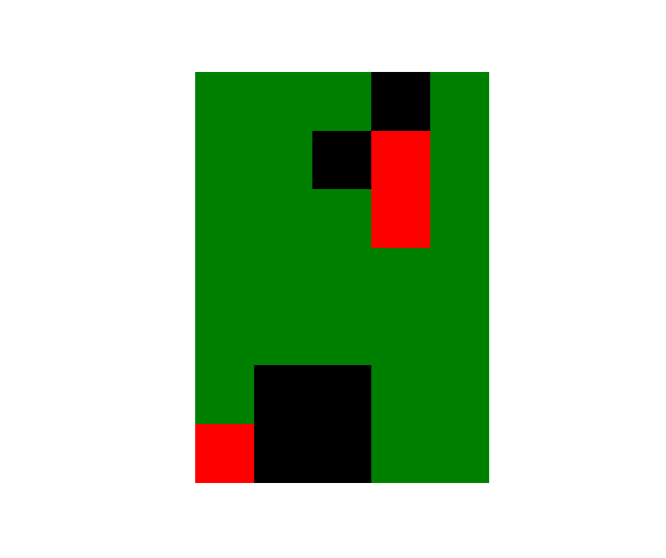

In [144]:
env = gym.make('gym_cpr_grid:CPRGridEnv-v0', n_agents=3, grid_width=5, grid_height=7)
observations = env.reset()
fig, ax, img = env.plot(env.render('rgb_array'))
for _ in range(env.max_steps):
    display.display(plt.gcf())
    action_dict = {h: env.action_space.sample() for h in range(env.n_agents)}
    print(action_dict)
    observations, rewards, dones, infos = env.step(action_dict)
    print(infos)
    display.clear_output(wait=True)
    img.set_data(env.render(mode='rgb_array'))
env.close()

## DQN

In [61]:
%tensorboard --logdir "~/ray_results"

In [163]:
ModelCatalog.register_custom_model("fcn", models.FCNetwork)

In [164]:
reporter = JupyterNotebookReporter(
    overwrite=True, 
    metric_columns={
        "custom_metrics/efficiency_mean": "U",
        "custom_metrics/equality_mean": "E",
        "custom_metrics/sustainability_mean": "S",
        "custom_metrics/peace_mean": "P"
    }
)

In [166]:
experiment_analysis = tune.run(
    DQNTrainer, 
    config={
        "env": "gym_cpr_grid:CPRGridEnv-v0", 
        "env_config": {
            "n_agents": 3,
            "grid_width": 5,
            "grid_height": 7,
            "tagging_ability": False
        }, 
        "num_workers": 1, 
        "framework": "torch",
        "model": {
            "custom_model": "fcn",
            "fcnet_hiddens": [32, 32],
            "fcnet_activation": "relu",
        },
        "exploration_config": {
            "type": "EpsilonGreedy",
            "initial_epsilon": 1.0,
            "final_epsilon": 0.1,
            "epsilon_timesteps": env.max_steps,
        },
        "callbacks": metrics.SocialOutcomeMetrics,
        "logger_config": {
            "wandb": {
                "project": "cpr-appropriation",
                "api_key_file": "./wandb_api_key_file",
                "log_config": True,
                'sync_tensorboard': True,
            }
        }
    },
    progress_reporter=reporter,
    loggers=DEFAULT_LOGGERS + (WandbLogger, )
)

Trial name,status,loc,U,E,S,P
DQN_gym_cpr_grid:CPRGridEnv-v0_ff9d7_00000,RUNNING,192.168.1.110:70670,0.444304,0.965422,252.159,nan


(pid=70670) 2021-08-17 14:17:23,910	ERROR worker.py:421 -- SystemExit was raised from the worker
(pid=70670) Traceback (most recent call last):
(pid=70670)   File "python/ray/_raylet.pyx", line 632, in ray._raylet.task_execution_handler
(pid=70670)   File "python/ray/_raylet.pyx", line 486, in ray._raylet.execute_task
(pid=70670)   File "python/ray/_raylet.pyx", line 523, in ray._raylet.execute_task
(pid=70670)   File "python/ray/_raylet.pyx", line 530, in ray._raylet.execute_task
(pid=70670)   File "python/ray/_raylet.pyx", line 534, in ray._raylet.execute_task
(pid=70670)   File "python/ray/_raylet.pyx", line 484, in ray._raylet.execute_task.function_executor
(pid=70670)   File "/Users/jobs/Github/cpr-appropriation/venv/lib/python3.9/site-packages/ray/_private/function_manager.py", line 563, in actor_method_executor
(pid=70670)     return method(__ray_actor, *args, **kwargs)
(pid=70670)   File "/Users/jobs/Github/cpr-appropriation/venv/lib/python3.9/site-packages/ray/tune/trainable.p

Process _WandbLoggingProcess-11:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/jobs/Github/cpr-appropriation/venv/lib/python3.9/site-packages/ray/tune/integration/wandb.py", line 200, in run
    result = self.queue.get()
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.frame

KeyboardInterrupt: 

In [77]:
experiment_analysis.results_df

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,agent_timesteps_total,done,episodes_total,...,info.learner.default_policy.td_error,config.tf_session_args.gpu_options.allow_growth,config.tf_session_args.device_count.CPU,info.learner.default_policy.learner_stats.allreduce_latency,info.learner.default_policy.learner_stats.grad_gnorm,info.learner.default_policy.learner_stats.cur_lr,info.learner.default_policy.learner_stats.mean_q,info.learner.default_policy.learner_stats.min_q,info.learner.default_policy.learner_stats.max_q,info.learner.default_policy.learner_stats.mean_td_error
trial_id,,,,,,,,,,,,,,,,,,,,,
0bdeb_00000,1321.0,408.0,864.5,1000.0,0,1,7056,7056,False,2,...,"[-0.03420925, 0.017646313, 0.23368692, 0.65992...",True,1,0.0,0.17243336,0.0005,4.851447,3.356795,6.587478,0.132203
